In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from PIL import Image

import scipy.misc

import dense_correspondence_manipulation.utils.utils as utils
utils.add_dense_correspondence_to_python_path()

import dense_correspondence
from dense_correspondence.evaluation.evaluation import *
import dense_correspondence.correspondence_tools.correspondence_plotter as correspondence_plotter
import dense_correspondence.correspondence_tools.correspondence_finder as correspondence_finder
from dense_correspondence.correspondence_tools.correspondence_finder import random_sample_from_masked_image, pinhole_projection_image_to_world
from dense_correspondence.dataset.dense_correspondence_dataset_masked import ImageType
from dense_correspondence.network.dense_correspondence_network import DenseCorrespondenceNetwork
import dense_correspondence.evaluation.plotting as dc_plotting
%matplotlib inline 
utils.set_cuda_visible_devices([0])

setting CUDA_VISIBLE_DEVICES =  0,


In [2]:
config_filename = os.path.join(utils.getDenseCorrespondenceSourceDir(), 'config', 
                               'dense_correspondence', 'evaluation', 'evaluation.yaml')
config = utils.getDictFromYamlFilename(config_filename)
dce = DenseCorrespondenceEvaluation(config)
DCE = DenseCorrespondenceEvaluation
# dcn = dce.load_network_from_config("cup_bottlesauce_elephant_cat_pear_unit_16") # this worked pretty well
dcn = dce.load_network_from_config("thingiverse_multi_rgb_unit_16") 

dataset = dcn.load_training_dataset()
camera_intrinsics = dataset.get_camera_intrinsics("elephant")

/home/davidtseng/pytorch-dense-correspondence/env/local/lib/python2.7/site-packages/torch/nn/modules/module.py:482: UserWarning: src is not broadcastable to dst, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  own_state[name].copy_(param)


Using SpartanDataset:
   - in train mode
   - number of scenes 126
   - total images:     78246


In [3]:
def match_index_and_norm_diff(query, features, cond=None):
    """
    Assumes that query and features both have shape (N, D).
    query: ndarray (D,)
    features: ndarray (N, D)    
    """
    
    if cond is None: 
        norm_diffs = np.sqrt(np.sum(np.square(features - query), axis=1)) 
        
    elif cond == "ppf":
        f1 = features[:, 1:]
        D = f1.shape[1]
        f2 = np.concatenate((f1[:, D//2:], f1[:, :D//2]), axis=1)
                
        norm_diffs1 = np.sqrt(np.sum(np.square(f1 - query[1:]), axis=1))
        norm_diffs2 = np.sqrt(np.sum(np.square(f2 - query[1:]), axis=1))
        norm_diffs = np.minimum(norm_diffs1, norm_diffs2)
    
        feature_cond = features[:, 0]
        query_cond = query[0]
        mask = np.logical_and(feature_cond > 5./7*query_cond, feature_cond < 9./7*query_cond).astype(np.float)
        norm_diffs = mask * norm_diffs + np.nan_to_num((1-mask) * float("inf") * np.ones(norm_diffs.shape))
    else:
        assert 1 == 0 
        
    best_match_index = np.argmin(norm_diffs)
    best_match_diff = norm_diffs[best_match_index]
    result = np.array([best_match_index, best_match_diff])
        
    #         candidate_indices = np.argwhere(np.logical_and(ppfs[:,0] > 5/7*ppf_target[0], ppfs[:,0] < 9/7*ppf_target[0])).T[0]

        
    return result

def simple_match(f1, f2, cond=None):
    """
    Simple brute force matching between features1 and features2.
    f1: ndarray of shape (N, ... )
    f2: ndarray of shape (N, ....)
    fn: None, "ppf"
    Returns indices of matches. Also does some filtering 
    to make sure that the best match of f1 is the best match of f2. 
    """
    
    f1 = f1.reshape((f1.shape[0], -1)) 
    f2 = f2.reshape((f2.shape[0], -1))

    f1_matches = np.apply_along_axis(lambda x: match_index_and_norm_diff(x, f2, cond), 1, f1)
    f2_matches = np.apply_along_axis(lambda x: match_index_and_norm_diff(x, f1, cond), 1, f2)
    
    best_matches = []
    for i in range(f1_matches.shape[0]):
        norm_diff = f1_matches[i, 1]
        best_match_index = int(f1_matches[i, 0])
        if f2_matches[best_match_index, 0] == i: # If they're the best matches of each other
            best_matches.append((i, best_match_index, norm_diff))
            
    return best_matches


def draw_orb_matches(img1, kp1, des1, img2, kp2, des2, match_type="hamming", num_matches=10):
    dist = 0.01 # placeholder constant for opencv

    if match_type == "hamming": 
        print("Using openCV norm_hammings")
        # create BFMatcher object
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

        # Match descriptors.    
        matches = bf.match(des1,des2)
    else:
        print("Using simple match")
        best_matches_lst = simple_match(des1, des2)
        matches = [cv2.DMatch(x[0], x[1], x[2]) for x in best_matches_lst]

    # Sort them in the order of their distance.
    matches = sorted(matches, key = lambda x:x.distance)

    # Draw first 10 matches.
    img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches[:num_matches], None, flags=2)

    plt.figure(figsize = (20, 10))
    plt.imshow(img3)
    plt.show()
    
def run_dcn_on_image(dcn, dataset, img):
    """
    Run DCN on PIL img. use of dataset is a hack, just need to ge the descriptor image stats 
    which actually just uses a constant for std and mean. 
    """
    rgb_a_tensor = dataset.rgb_image_to_tensor(img)
    res_a = dcn.forward_single_image_tensor(rgb_a_tensor).data.cpu().numpy()
    descriptor_image_stats = dcn.descriptor_image_stats
    res_a_norm = dc_plotting.normalize_descriptor(res_a, descriptor_image_stats["mask_image"])
    return res_a_norm

def run_ORB(heap, target, num_matches=5):
    """Run baseline ORB. """
    orb = cv2.ORB_create()

    kp1, des1 = orb.detectAndCompute(target,None)
    kp2, des2 = orb.detectAndCompute(heap,None)
    
    draw_orb_matches(target, kp1, des1, heap, kp2, des2, num_matches=num_matches)

def run_ORB_and_dense_descriptors(dcn, dataset, heap_name, target_name, num_matches=5, image_type="depth"):
    """Use ORB keypoints + dense descriptors. """
    orb = cv2.ORB_create()
    
    if image_type == "rgb":
        target_img = Image.open("images/targets/{}/target_rgb.png".format(target_name)).convert('RGB')
    else:
        target_img = Image.open("images/targets/{}/target_depth.png".format(target_name)).convert('RGB')
    target = np.array(target_img)
    target_descriptors = run_dcn_on_image(dcn, dataset, target_img)
    target_mask = np.load("images/targets/{}/target_mask.npy".format(target_name)).astype(np.bool)

    if image_type == "rgb":
        heap_img_rgb = Image.open("images/heaps/{}/heap_rgb.png".format(heap_name)).convert('RGB')
    else:
        heap_img = Image.open("images/heaps/{}/heap_depth.png".format(heap_name)).convert('RGB')
    heap = np.array(heap_img)
    heap_descriptors = run_dcn_on_image(dcn, dataset, heap_img)
    obj1_mask = np.load("images/heaps/{}/obj1_mask.npy".format(heap_name)).astype(np.bool)
    obj2_mask = np.load("images/heaps/{}/obj2_mask.npy".format(heap_name)).astype(np.bool)
    
    # be careful, OpenCV format is  (u,v) = (right, down)
    kp1_map = lambda x: target_descriptors[x[1], x[0]]
    kp2_map = lambda x: heap_descriptors[x[1], x[0]]

    # # find the keypoints with ORB
    kp1 = orb.detect(target,None)
    kp1_array = np.array([x.pt for x in kp1]).reshape(-1, 2).astype(np.int)
    des1 = np.apply_along_axis(kp1_map, 1, kp1_array)
    
    kp2 = orb.detect(heap,None)
    kp2_array = np.array([x.pt for x in kp2]).reshape(-1, 2).astype(np.int)
    des2 = np.apply_along_axis(kp2_map, 1, kp2_array)
    draw_orb_matches(target, kp1, des1, heap, kp2, des2, num_matches=num_matches, match_type="simple")

def run_dense_descriptor_original_match(dcn, dataset, heap_name, target_name, num_matches=5, patch_size=None, image_type="depth"):
    """Use the original dense descriptor sampling + matching method"""
    
    if image_type == "rgb":
        target_img = Image.open("images/targets/{}/target_rgb.png".format(target_name)).convert('RGB')
    else:
        target_img = Image.open("images/targets/{}/target_depth.png".format(target_name)).convert('RGB')
    target = np.array(target_img)
    target_descriptors = run_dcn_on_image(dcn, dataset, target_img)
    target_mask = np.load("images/targets/{}/target_mask.npy".format(target_name)).astype(np.bool)
    
    if image_type == "rgb":
        heap_img_rgb = Image.open("images/heaps/{}/heap_rgb.png".format(heap_name)).convert('RGB')
    else:
        heap_img = Image.open("images/heaps/{}/heap_depth.png".format(heap_name)).convert('RGB')    
    heap = np.array(heap_img)
    heap_descriptors = run_dcn_on_image(dcn, dataset, heap_img)
    heap_mask = np.load("images/heaps/{}/heap_mask.npy".format(heap_name)).astype(np.bool)
    
    DCE.single_image_pair_qualitative_analysis(dcn, dataset, target, heap, target_mask, heap_mask, num_matches, patch_size)

def run_dense_descriptor_original_match_with_filtering(dcn, dataset, target, heap, target_mask, heap_mask, target_descriptors, heap_descriptors, top_num_matches=5):
    """Use the original dense descriptor sampling + matching method + some filtering"""    
    num_heap_samples = 1000
    num_target_samples = 400
    
    heap_sampled_idx_list = random_sample_from_masked_image(heap_mask[:, :, 0].astype(np.int), num_heap_samples)
    
    target_sampled_idx_list = random_sample_from_masked_image(target_mask[:, :, 0].astype(np.int), num_target_samples)
    
    heap_sample_descriptors = []
    for i in range(num_heap_samples):
        heap_sample_descriptors.append(heap_descriptors[heap_sampled_idx_list[0][i], heap_sampled_idx_list[1][i], :])
    target_sample_descriptors = []
    for i in range(num_target_samples):
        target_sample_descriptors.append(target_descriptors[target_sampled_idx_list[0][i], target_sampled_idx_list[1][i], :])
    heap_sample_descriptors = np.array(heap_sample_descriptors)
    target_sample_descriptors = np.array(target_sample_descriptors)
    
    best_matches_lst = simple_match(target_sample_descriptors, heap_sample_descriptors)
    best_matches_lst = sorted(best_matches_lst, key=lambda x: x[2])
    
    kp1, kp2, matches = [], [], []
    hist_x = []
    hist_y = []
    hist_values = []
    
    diam = 0.01 
    for x, match in enumerate(best_matches_lst):
        i, j, dist = match    
        kp1.append(cv2.KeyPoint(target_sampled_idx_list[1][i], target_sampled_idx_list[0][i], diam))
        kp2.append(cv2.KeyPoint(heap_sampled_idx_list[1][j], heap_sampled_idx_list[0][j], diam))
        
        hist_x.append(heap_sampled_idx_list[1][j])
        hist_y.append(heap_sampled_idx_list[0][j])
        hist_values.append(dist)
        
        matches.append(cv2.DMatch(x, x, dist))

#     matches = sorted(matches, key = lambda x:x.distance)
    
    img3 = cv2.drawMatches(target,kp1,heap,kp2,matches[:top_num_matches], None, flags=2)
    
    
    plt.figure(figsize = (20, 10))
    plt.imshow(img3)
    plt.show()
    
    
    plt.figure(figsize=(10, 10))
#     plt.scatter(hist_x[:top_num_matches], hist_y[:top_num_matches], color='r', alpha=0.5)
    plt.scatter(hist_x[:top_num_matches], hist_y[:top_num_matches], c=hist_values[:top_num_matches],  cmap="bwr_r", alpha=0.75)
    plt.colorbar()

    plt.imshow(heap)
    plt.show()

Heap: 0


/home/davidtseng/pytorch-dense-correspondence/env/local/lib/python2.7/site-packages/torch/nn/functional.py:1423: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.")


normalizing descriptor norm
normalizing descriptor norm
Using openCV norm_hammings


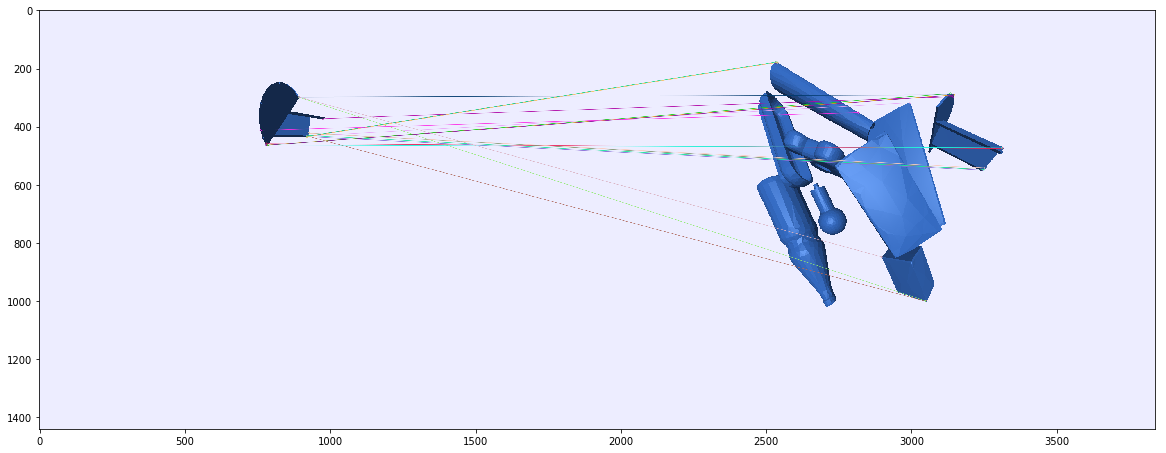

Heap: 1
normalizing descriptor norm
normalizing descriptor norm
Using openCV norm_hammings


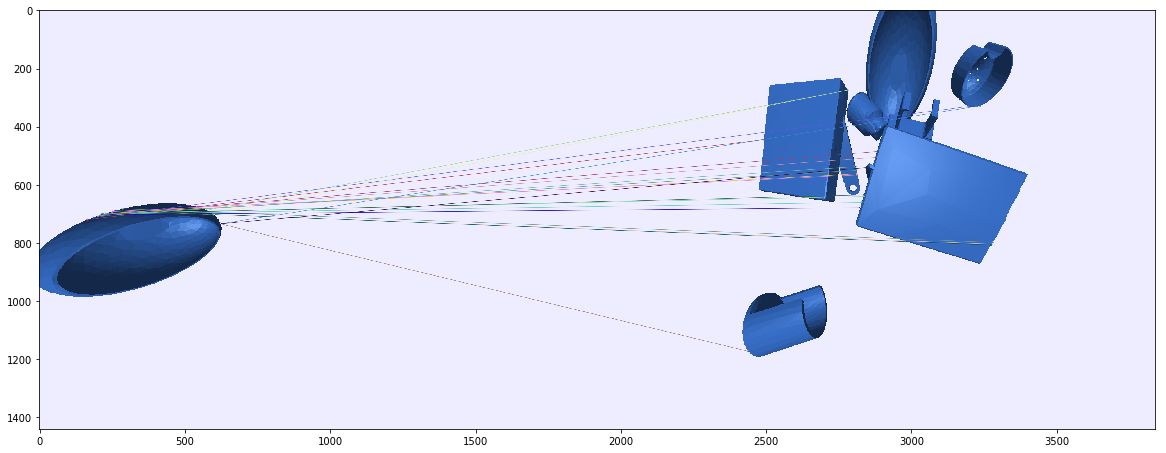

Heap: 3
normalizing descriptor norm
normalizing descriptor norm
Using openCV norm_hammings


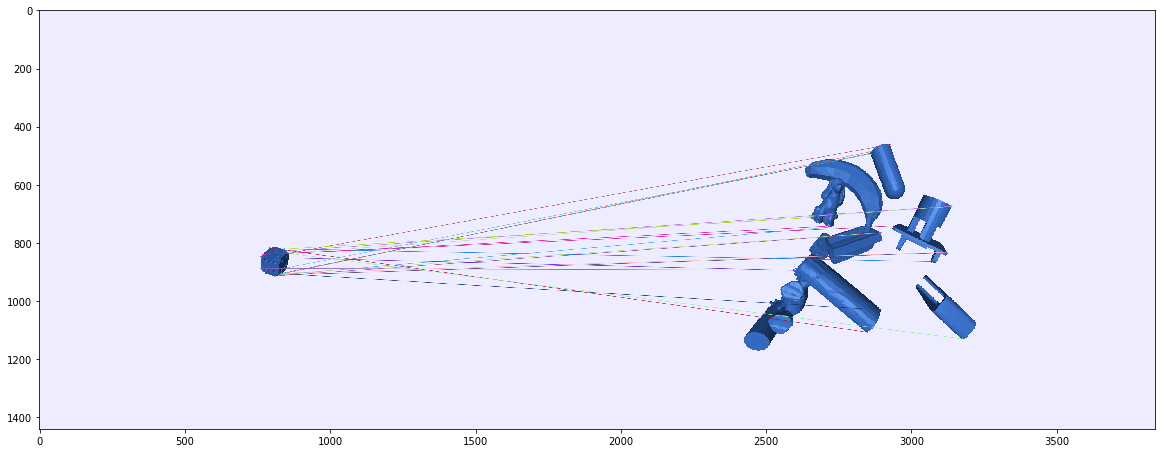

Heap: 4
normalizing descriptor norm
normalizing descriptor norm
Using openCV norm_hammings


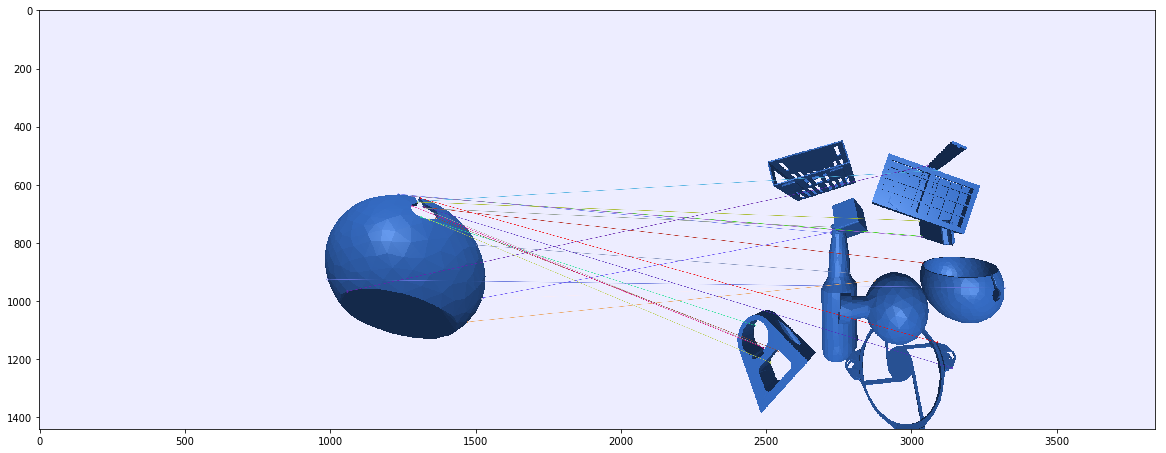

Heap: 5
normalizing descriptor norm
normalizing descriptor norm
Using openCV norm_hammings


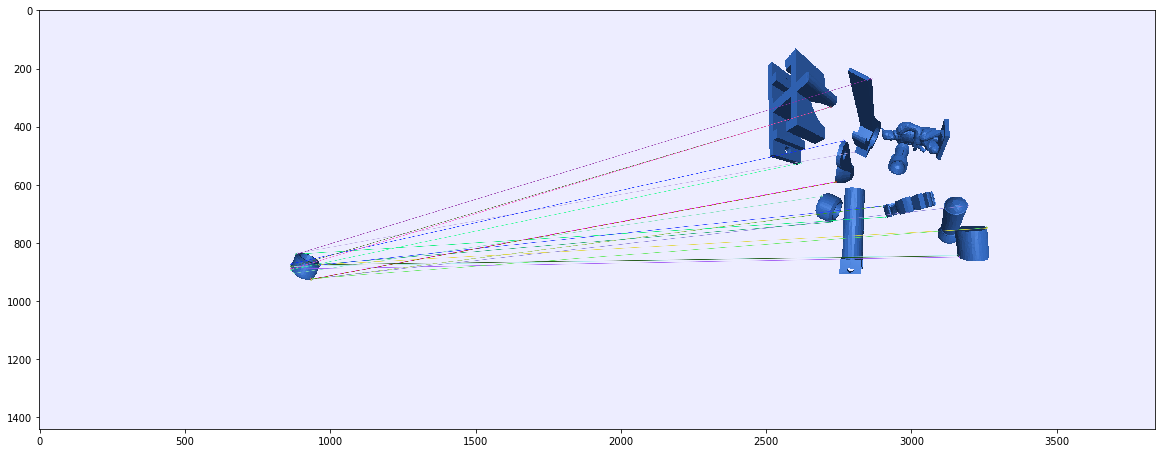

Heap: 7
normalizing descriptor norm
normalizing descriptor norm
Using openCV norm_hammings


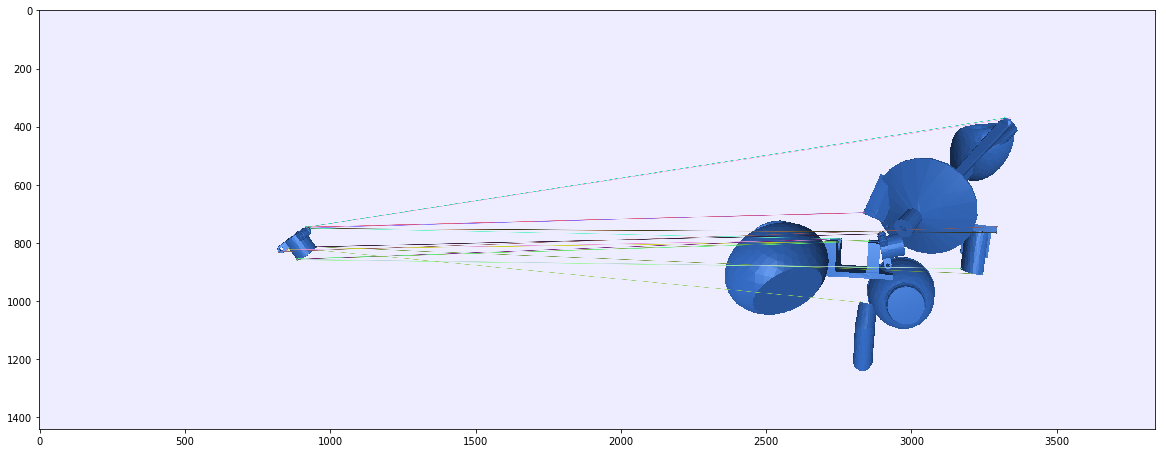

Heap: 8
normalizing descriptor norm
normalizing descriptor norm
Using openCV norm_hammings


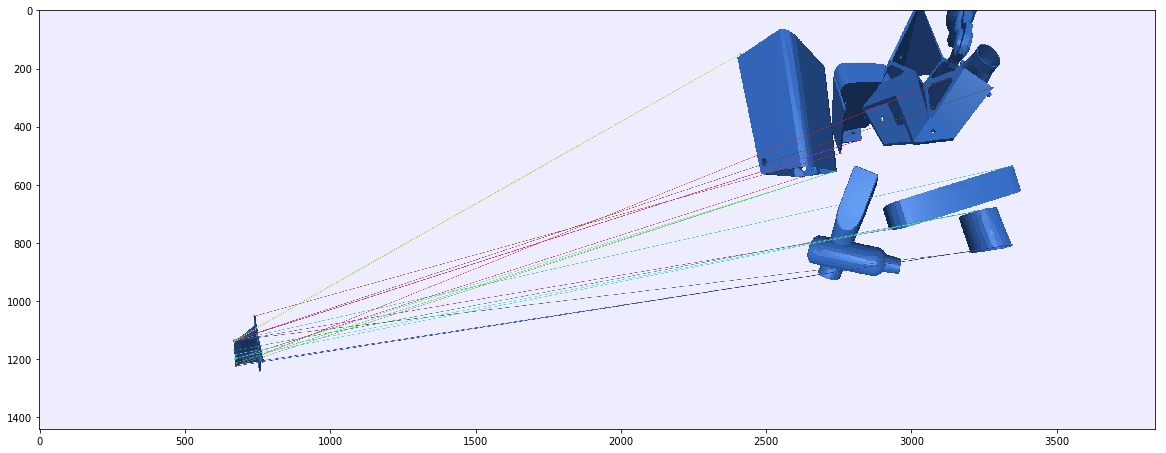

Heap: 9
normalizing descriptor norm
normalizing descriptor norm
Using openCV norm_hammings


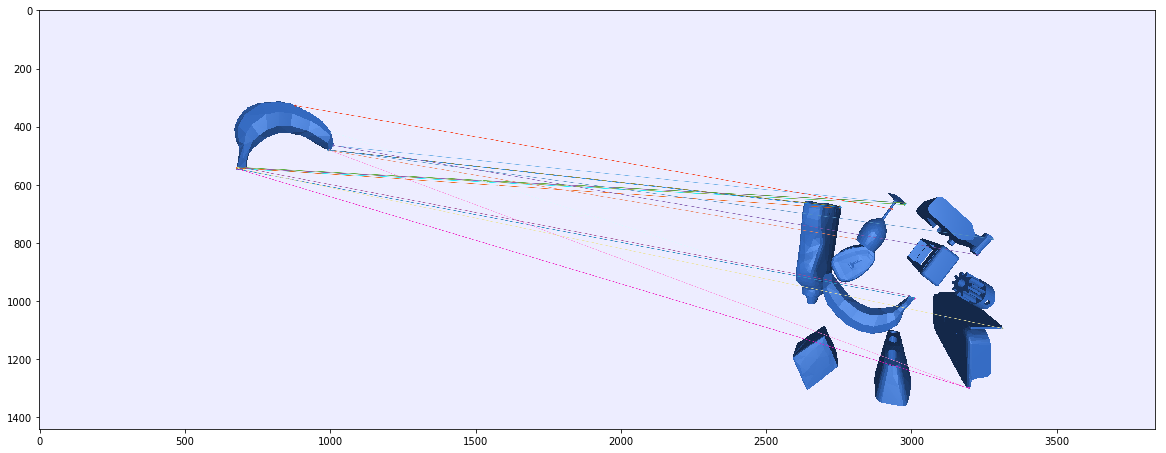

Heap: 10
normalizing descriptor norm
normalizing descriptor norm
Using openCV norm_hammings


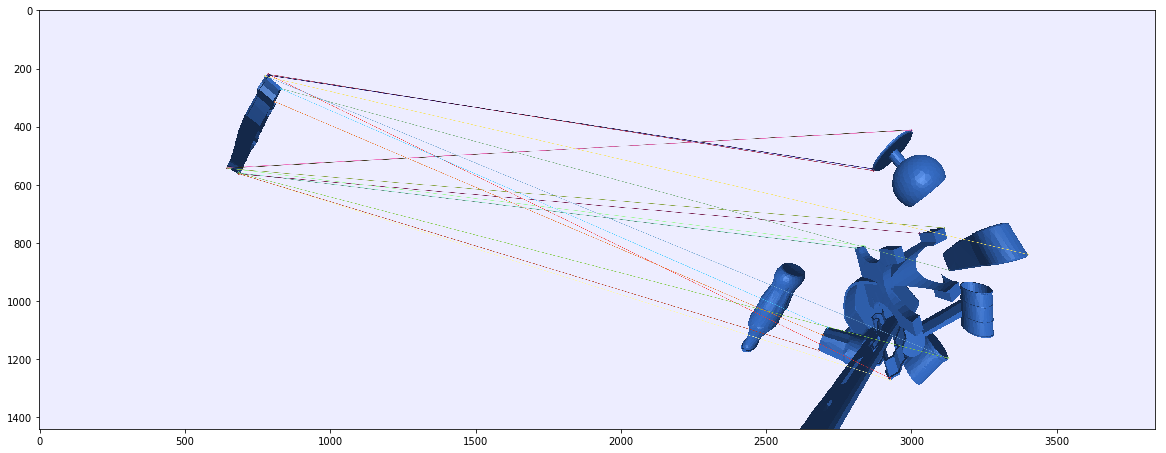

Heap: 11
normalizing descriptor norm
normalizing descriptor norm
Using openCV norm_hammings


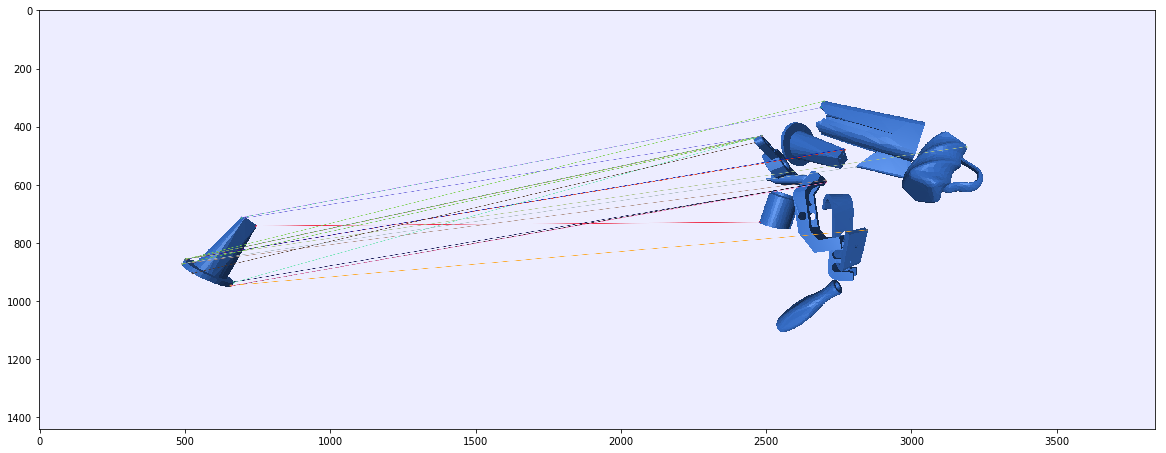

Heap: 12
normalizing descriptor norm
normalizing descriptor norm
Using openCV norm_hammings


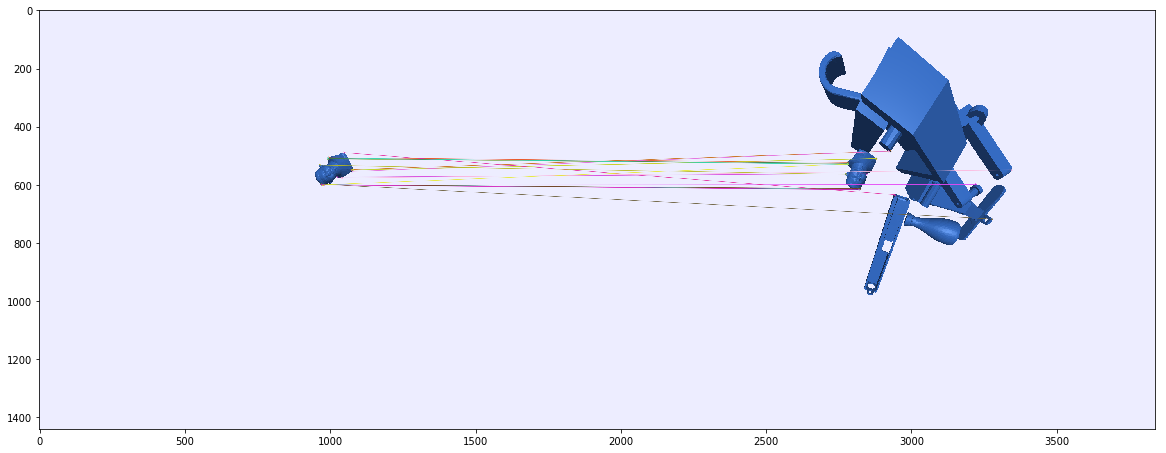

Heap: 13
normalizing descriptor norm
normalizing descriptor norm
Using openCV norm_hammings


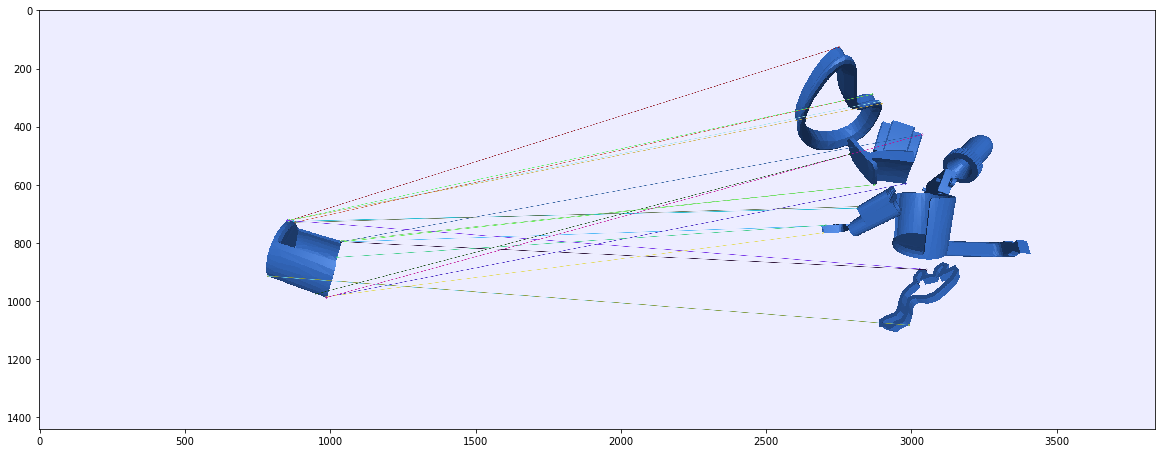

Heap: 14
normalizing descriptor norm
normalizing descriptor norm
Using openCV norm_hammings


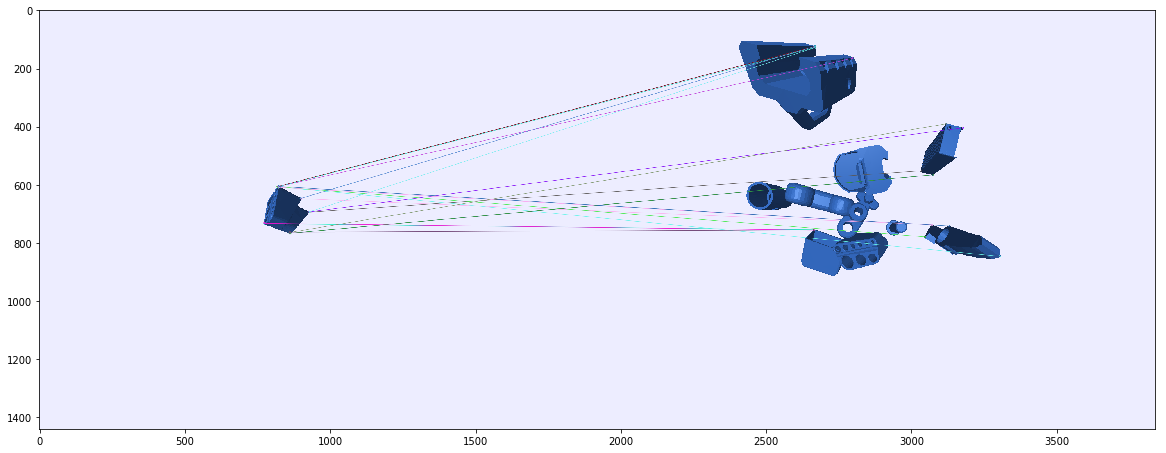

Heap: 15
normalizing descriptor norm
normalizing descriptor norm
Using openCV norm_hammings


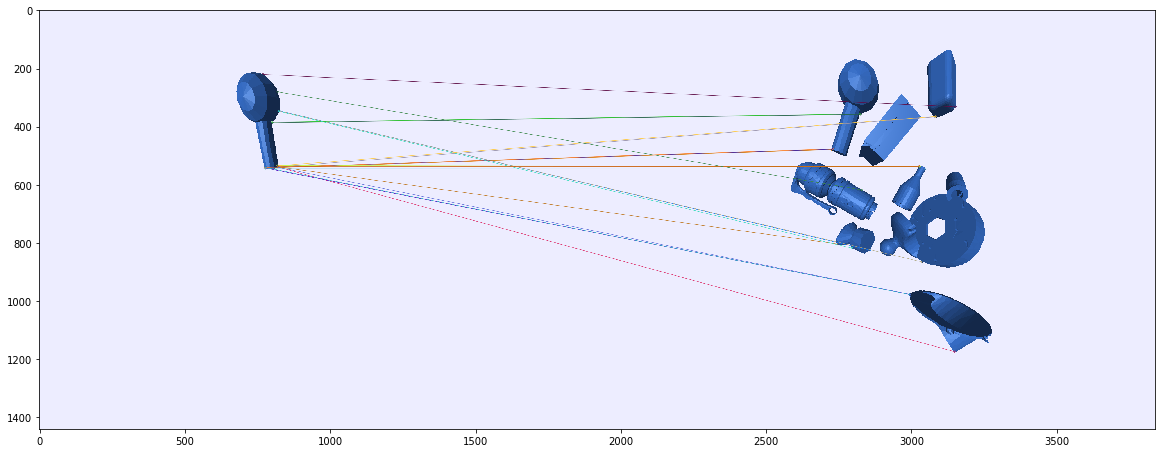

Heap: 16
normalizing descriptor norm
normalizing descriptor norm
Using openCV norm_hammings


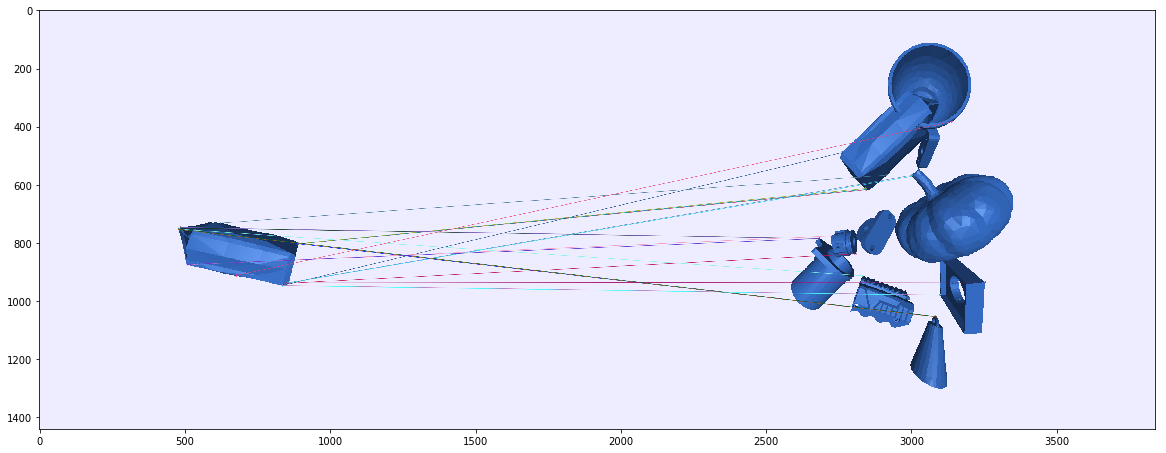

Heap: 17
normalizing descriptor norm
normalizing descriptor norm
Using openCV norm_hammings


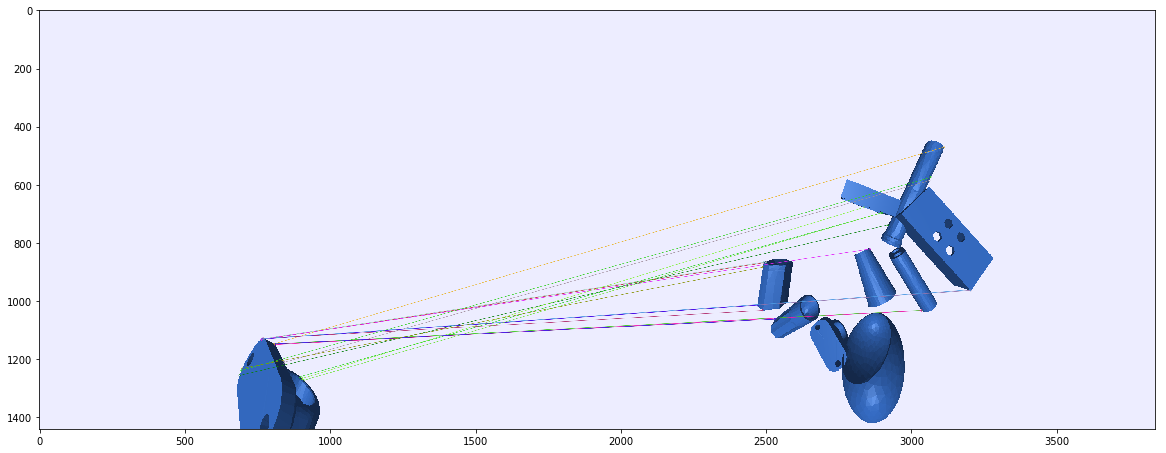

Heap: 18
normalizing descriptor norm
normalizing descriptor norm
Using openCV norm_hammings


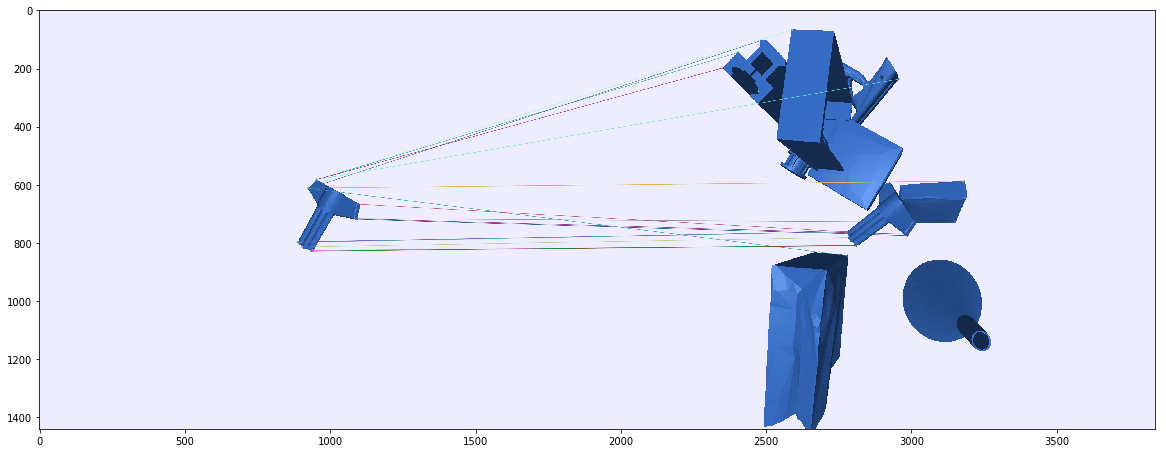

Heap: 19
normalizing descriptor norm
normalizing descriptor norm
Using openCV norm_hammings


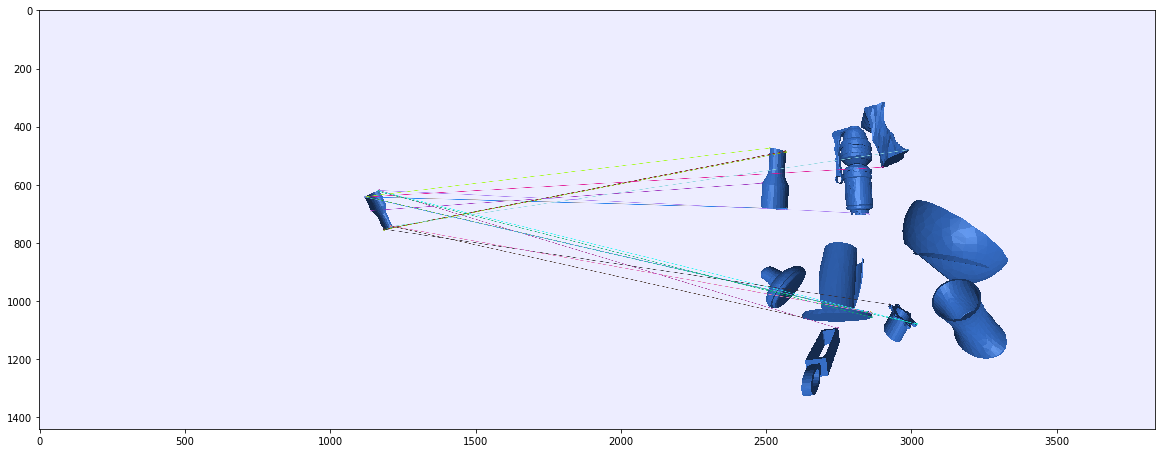

Heap: 20
normalizing descriptor norm
normalizing descriptor norm
Using openCV norm_hammings


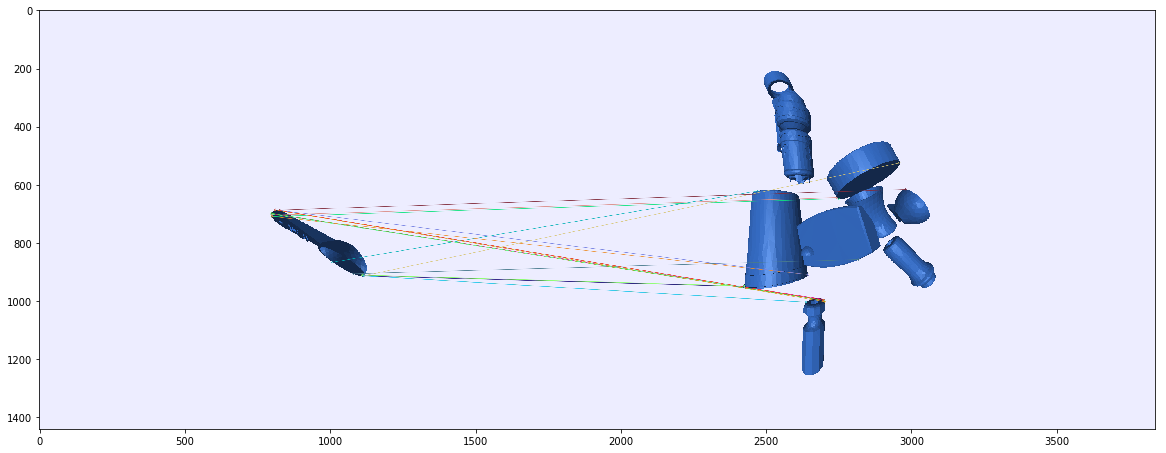

Heap: 21
normalizing descriptor norm
normalizing descriptor norm
Using openCV norm_hammings


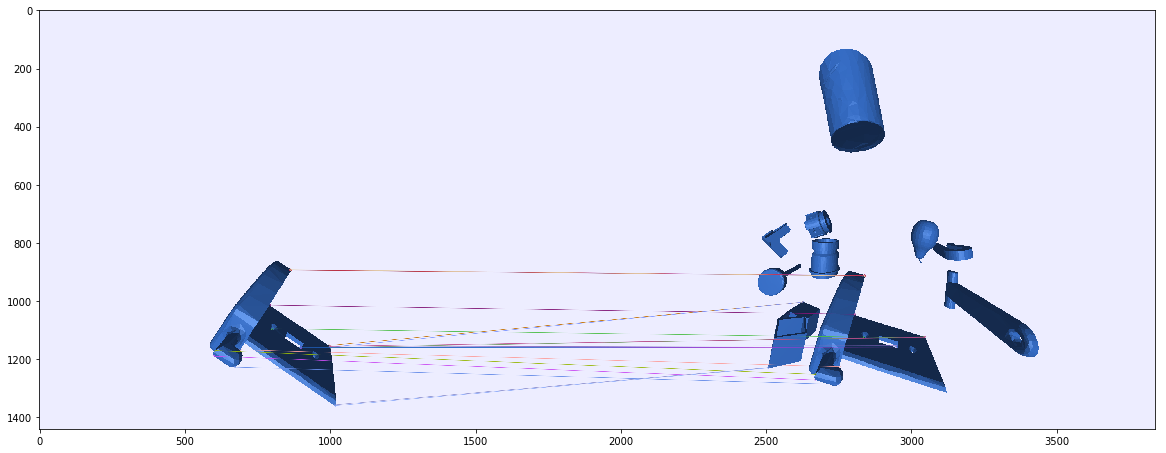

Heap: 22
normalizing descriptor norm
normalizing descriptor norm
Using openCV norm_hammings


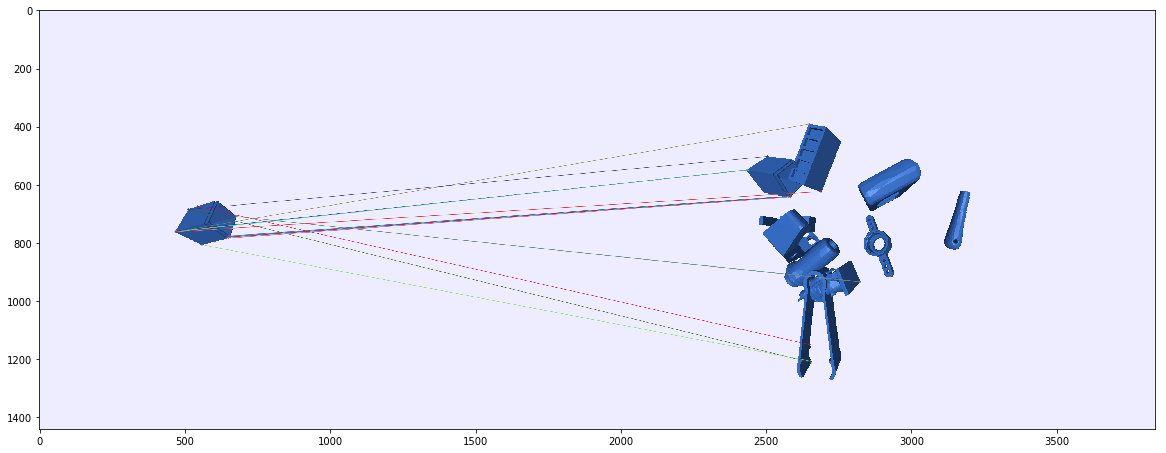

Heap: 23
normalizing descriptor norm
normalizing descriptor norm
Using openCV norm_hammings


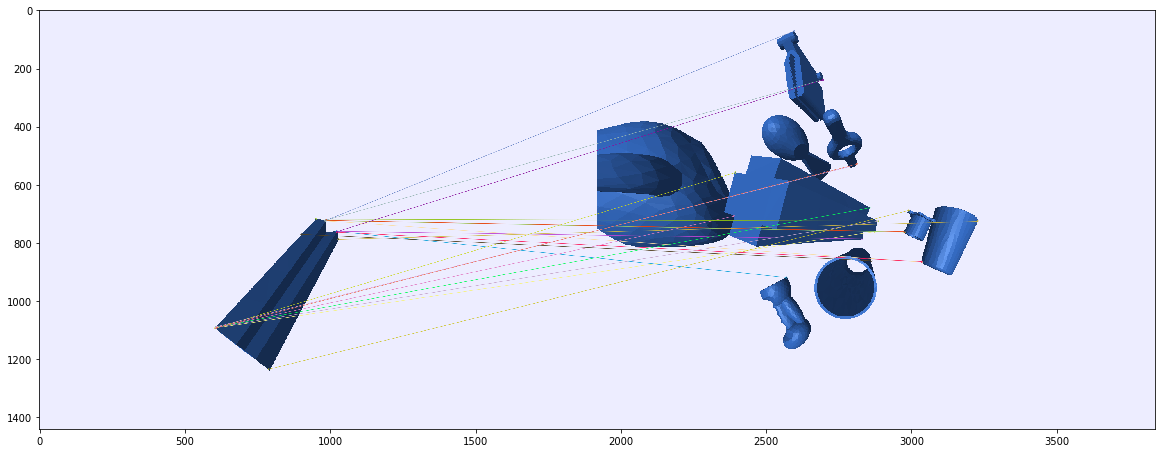

Heap: 24
normalizing descriptor norm
normalizing descriptor norm
Using openCV norm_hammings


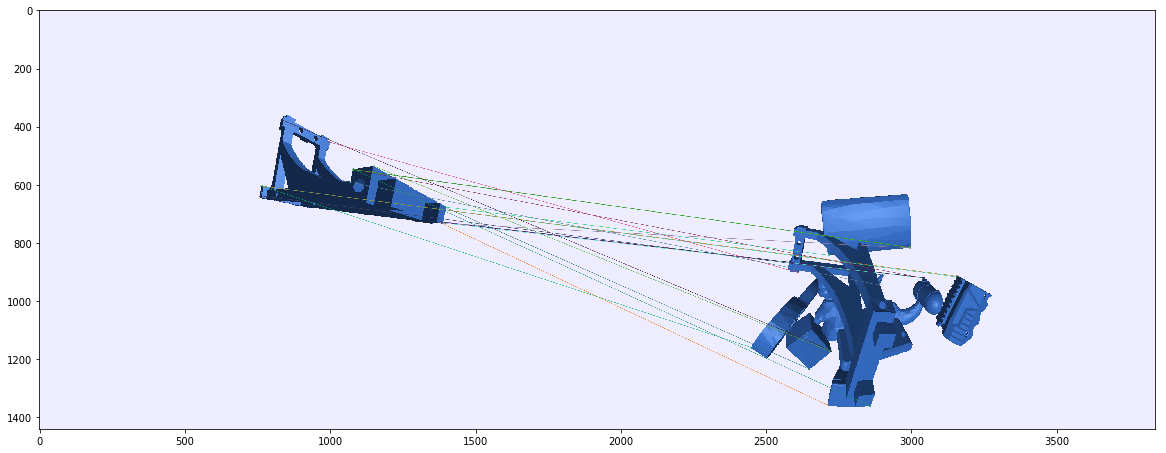

Heap: 25
normalizing descriptor norm
normalizing descriptor norm
Using openCV norm_hammings


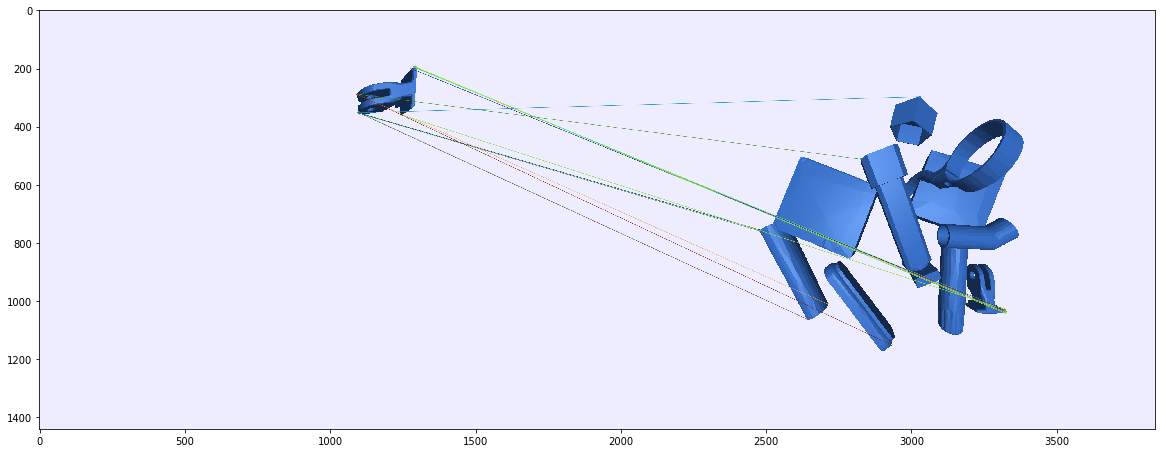

Heap: 26
normalizing descriptor norm
normalizing descriptor norm
Using openCV norm_hammings


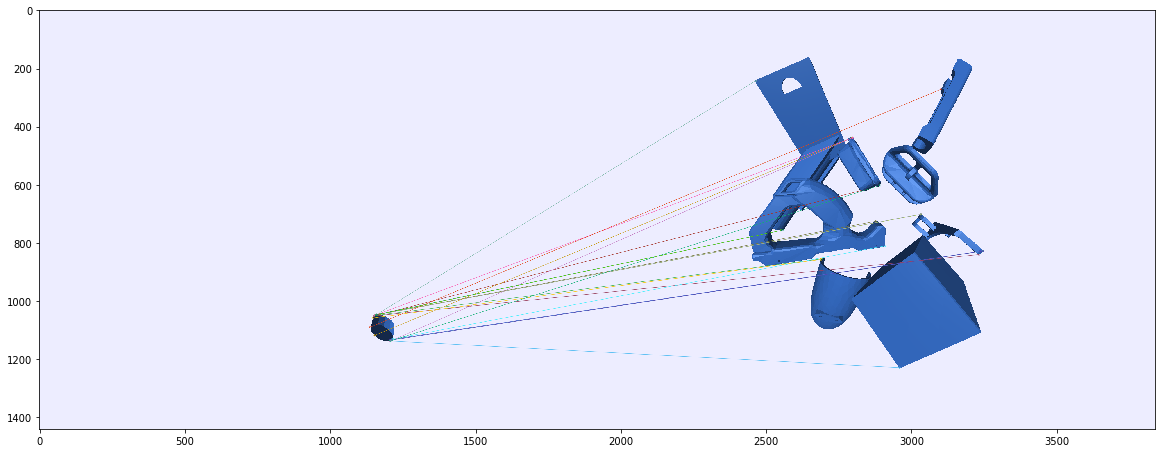

Heap: 27
normalizing descriptor norm
normalizing descriptor norm
Using openCV norm_hammings


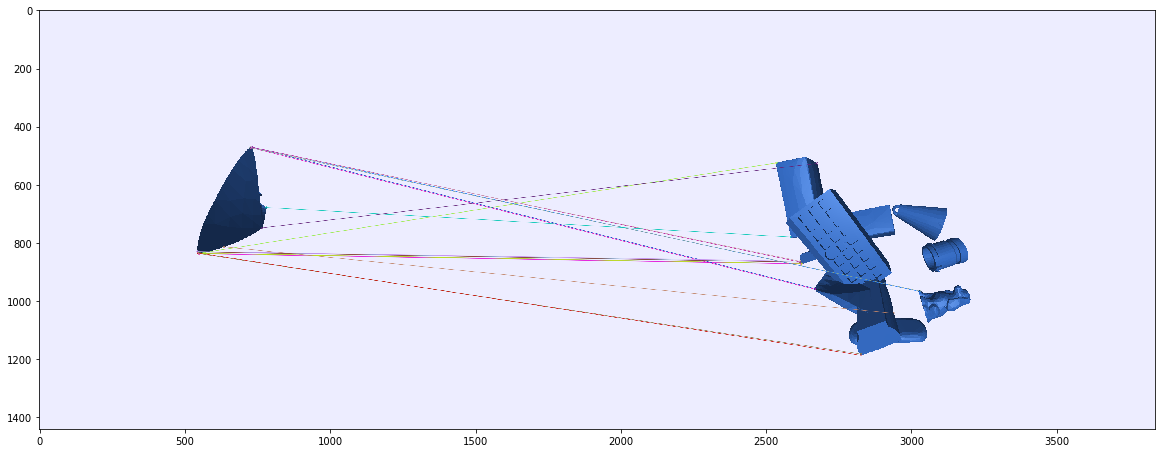

Heap: 28
normalizing descriptor norm
normalizing descriptor norm
Using openCV norm_hammings


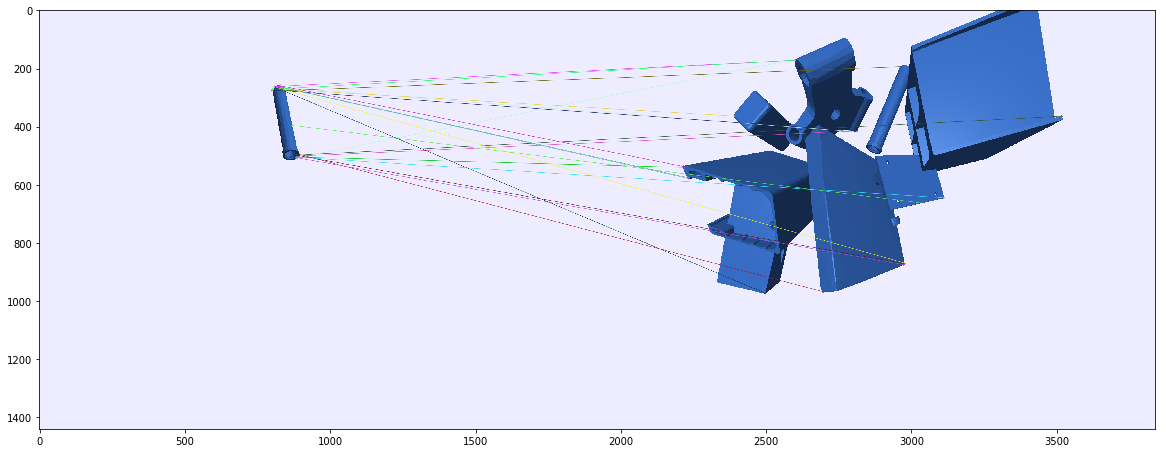

Heap: 29
normalizing descriptor norm
normalizing descriptor norm
Using openCV norm_hammings


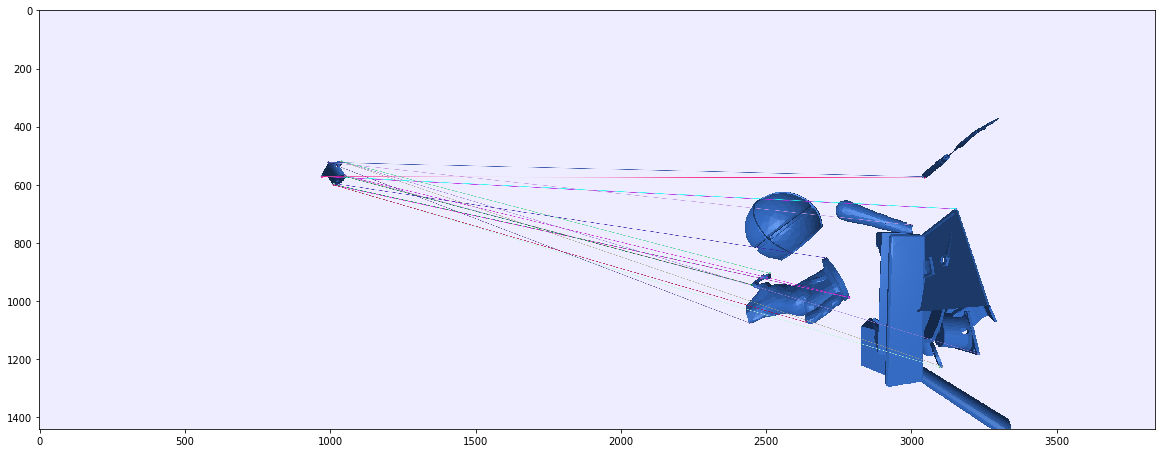

Heap: 30
normalizing descriptor norm
normalizing descriptor norm
Using openCV norm_hammings


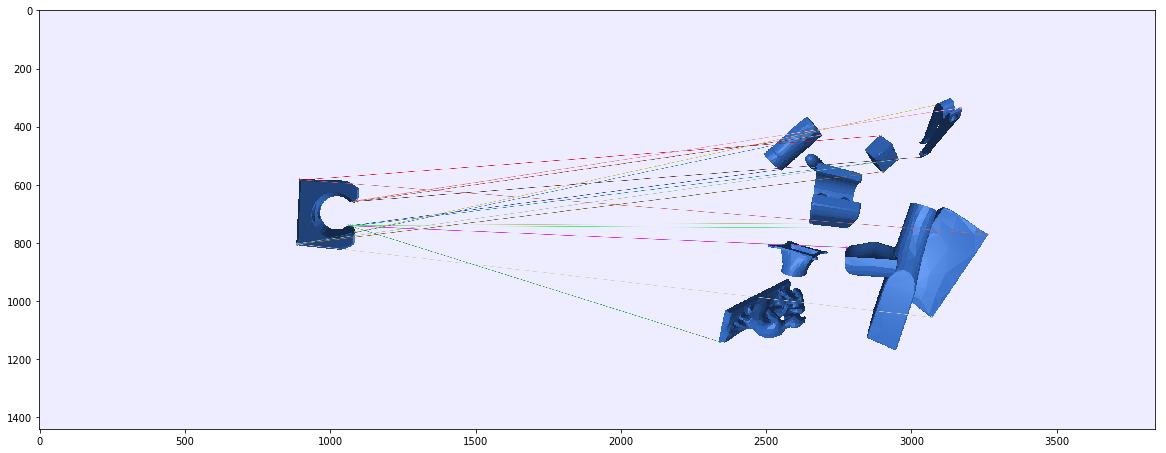

Heap: 31
normalizing descriptor norm
normalizing descriptor norm
Using openCV norm_hammings


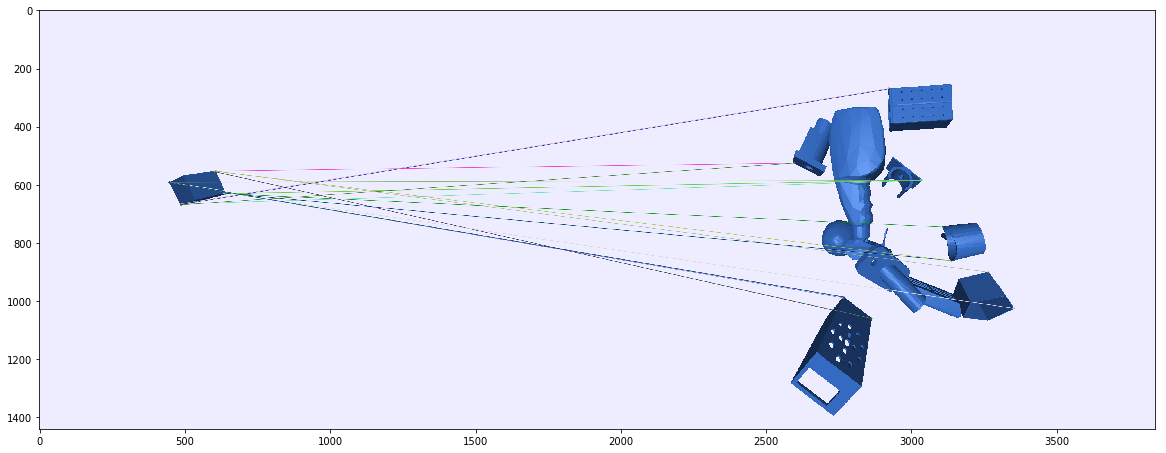

Heap: 32
normalizing descriptor norm
normalizing descriptor norm
Using openCV norm_hammings


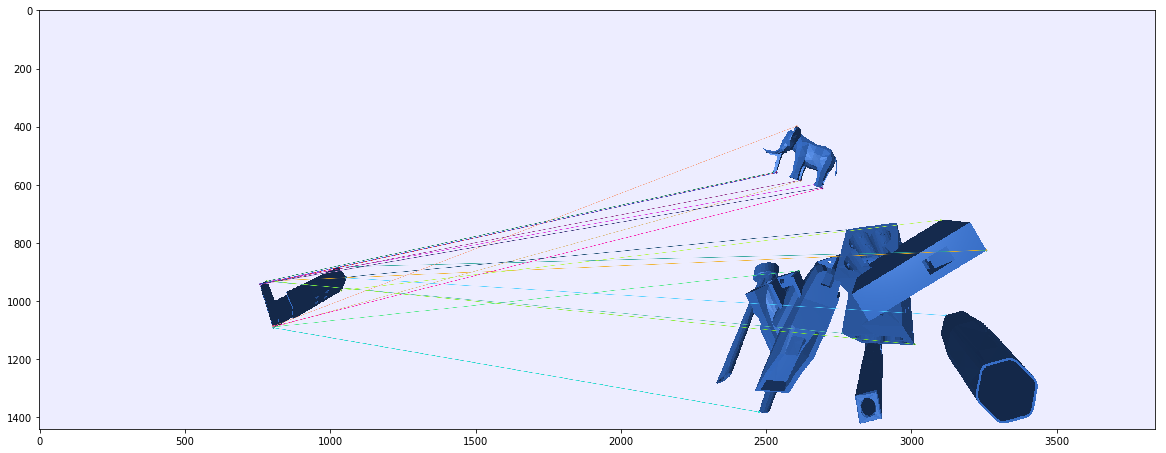

Heap: 33
normalizing descriptor norm
normalizing descriptor norm
Using openCV norm_hammings


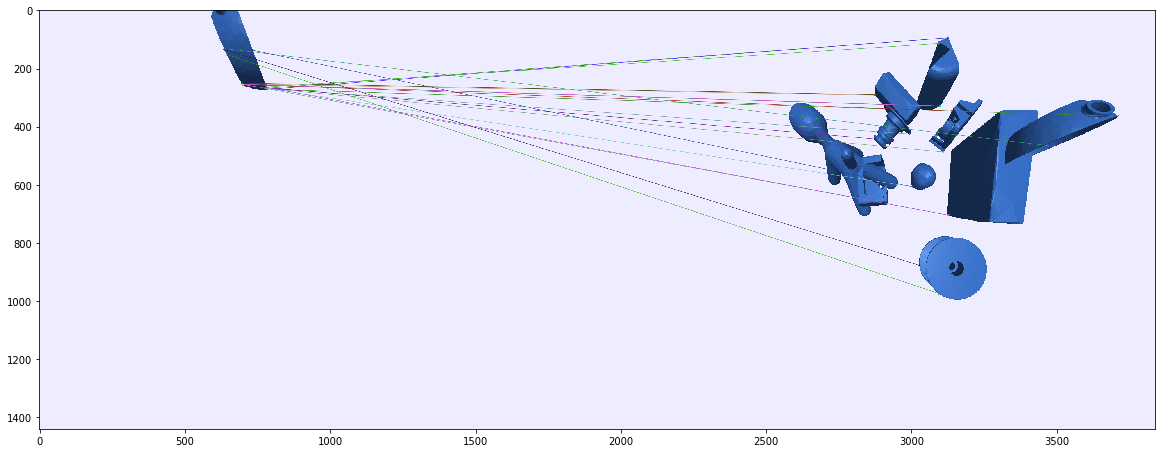

Heap: 34
normalizing descriptor norm
normalizing descriptor norm
Using openCV norm_hammings


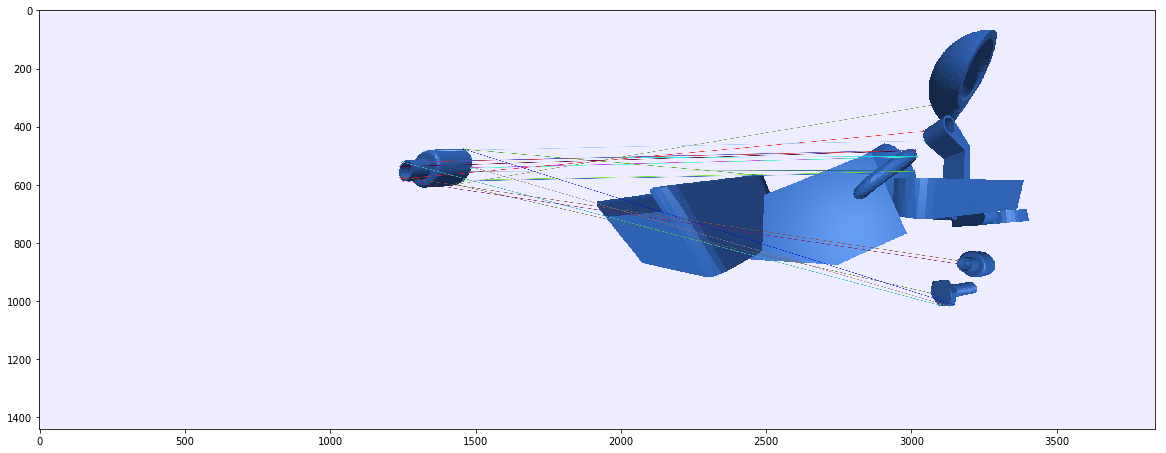

Heap: 35
normalizing descriptor norm
normalizing descriptor norm
Using openCV norm_hammings


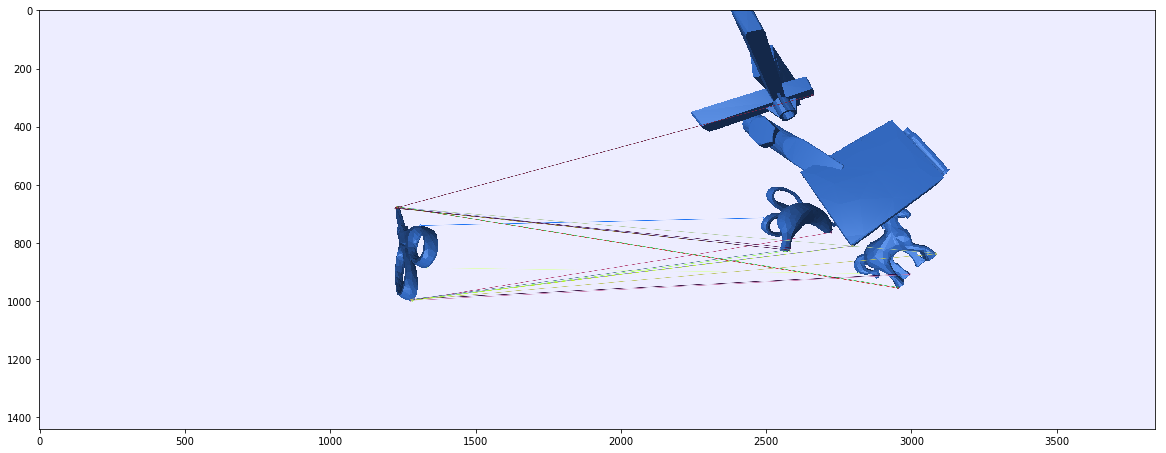

Heap: 36
normalizing descriptor norm
normalizing descriptor norm
Using openCV norm_hammings


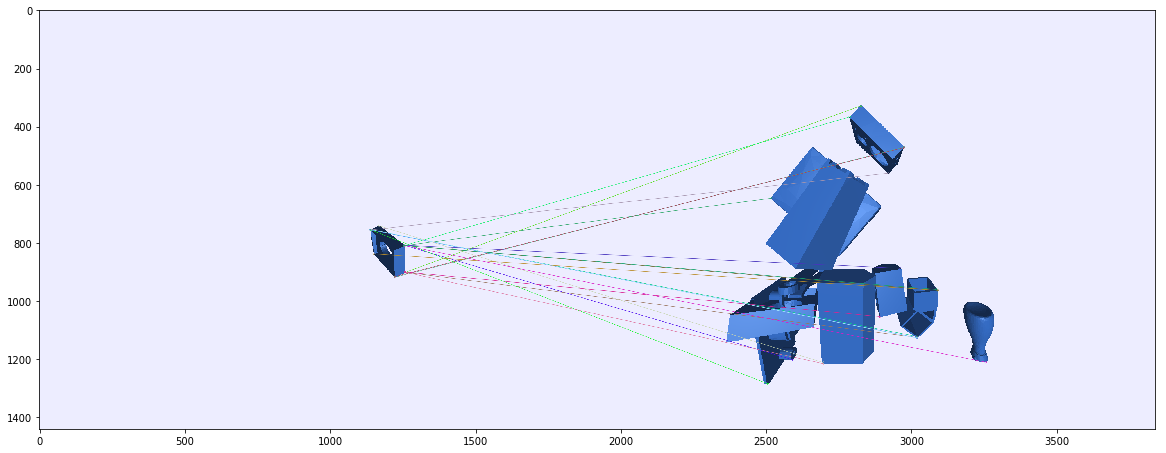

Heap: 37
normalizing descriptor norm
normalizing descriptor norm
Using openCV norm_hammings


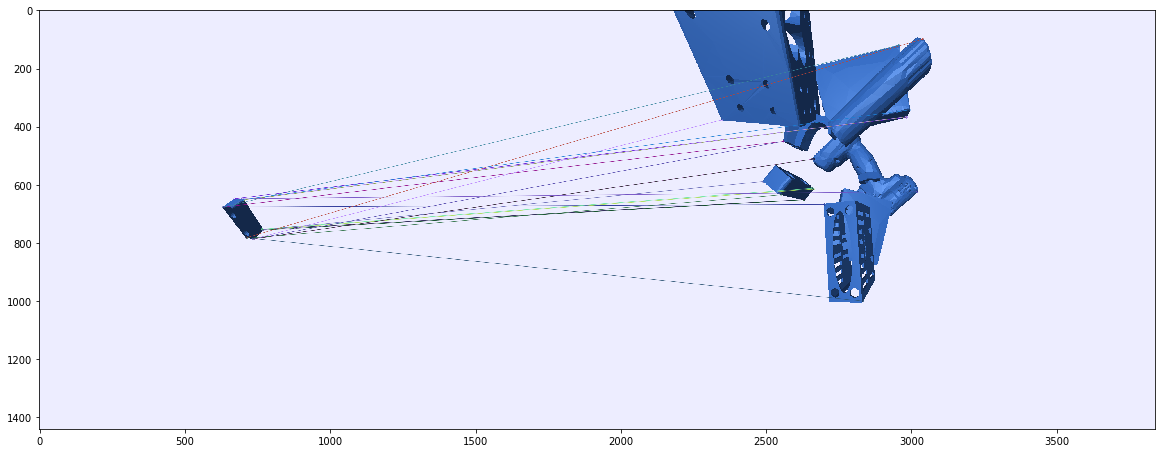

Heap: 38
normalizing descriptor norm
normalizing descriptor norm
Using openCV norm_hammings


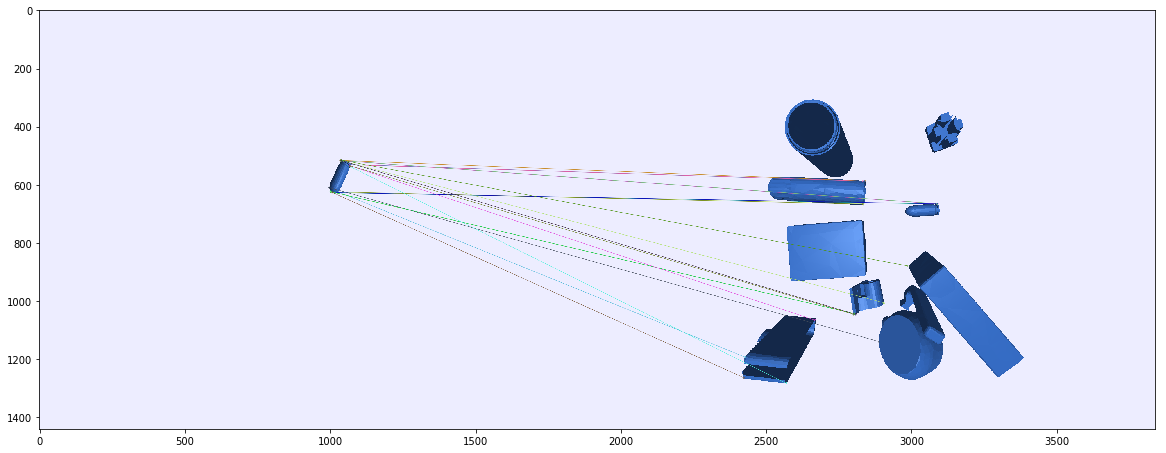

Heap: 39
normalizing descriptor norm
normalizing descriptor norm
Using openCV norm_hammings


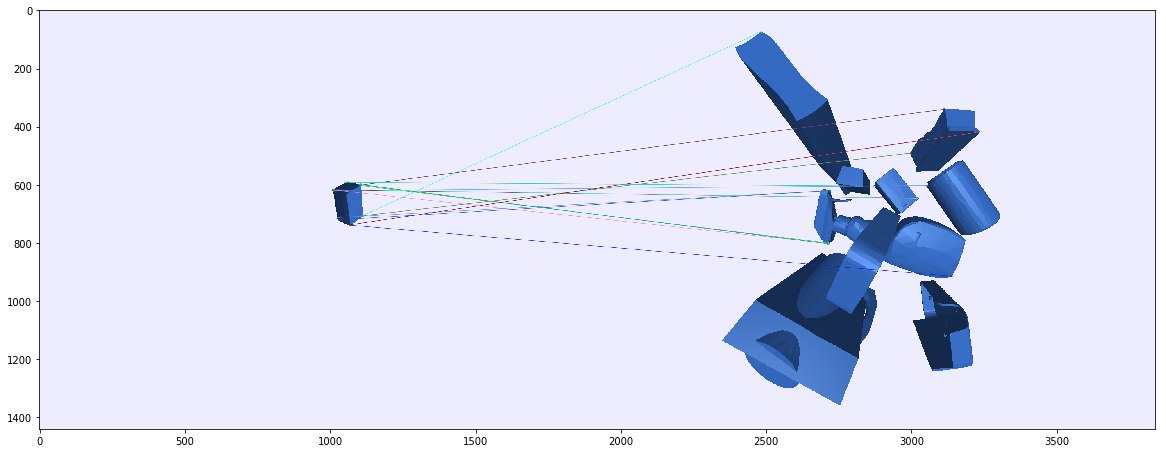

Heap: 40
normalizing descriptor norm
normalizing descriptor norm
Using openCV norm_hammings


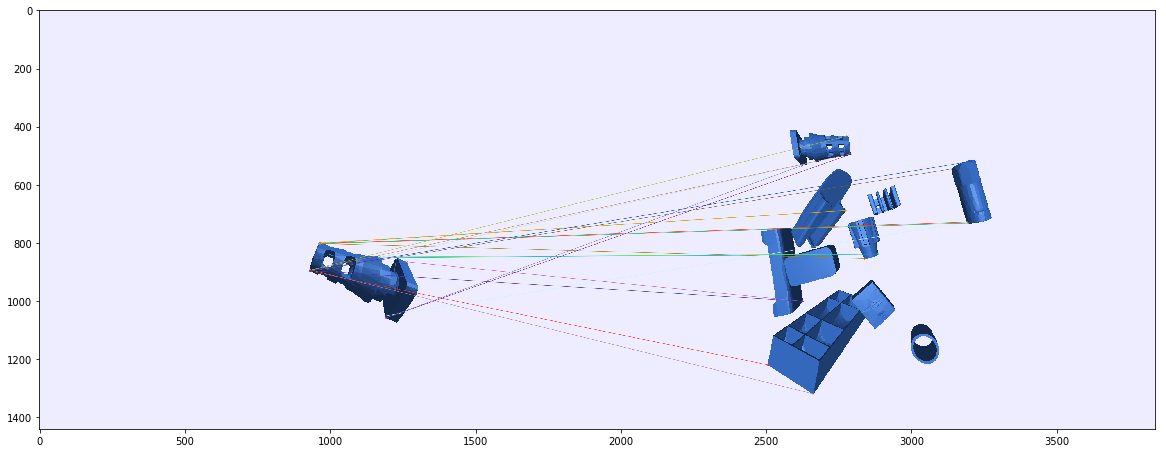

Heap: 41
normalizing descriptor norm
normalizing descriptor norm
Using openCV norm_hammings


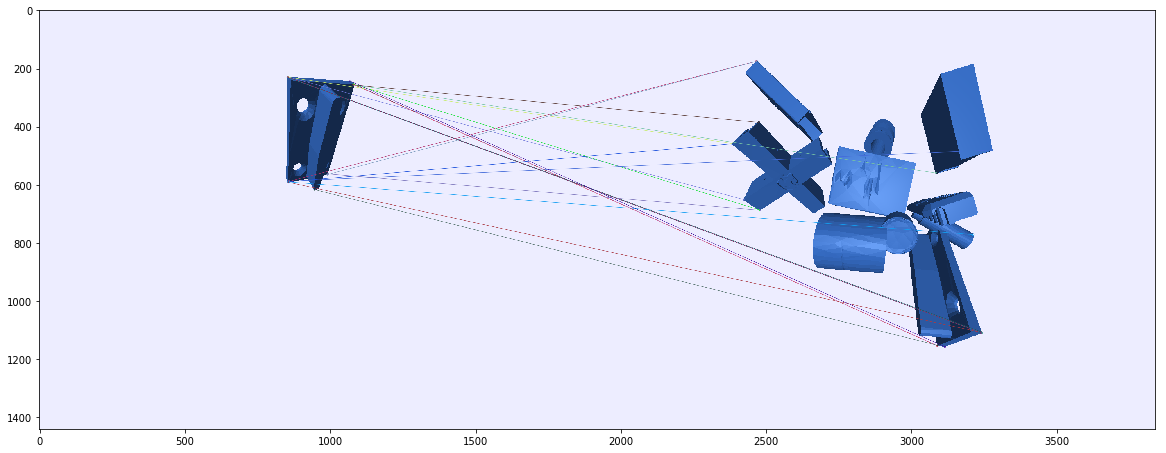

Heap: 42
normalizing descriptor norm
normalizing descriptor norm
Using openCV norm_hammings


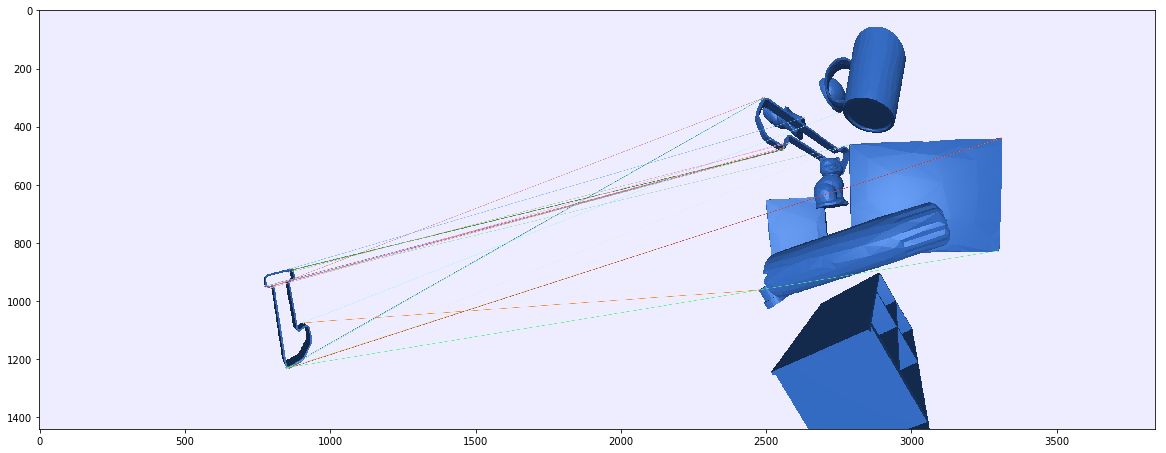

Heap: 43
normalizing descriptor norm
normalizing descriptor norm
Using openCV norm_hammings


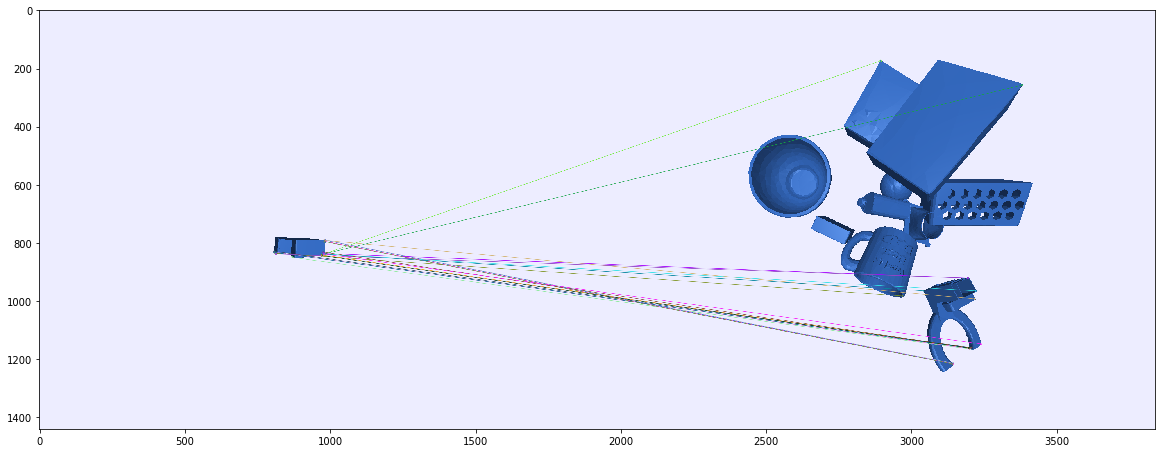

Heap: 44
normalizing descriptor norm
normalizing descriptor norm
Using openCV norm_hammings


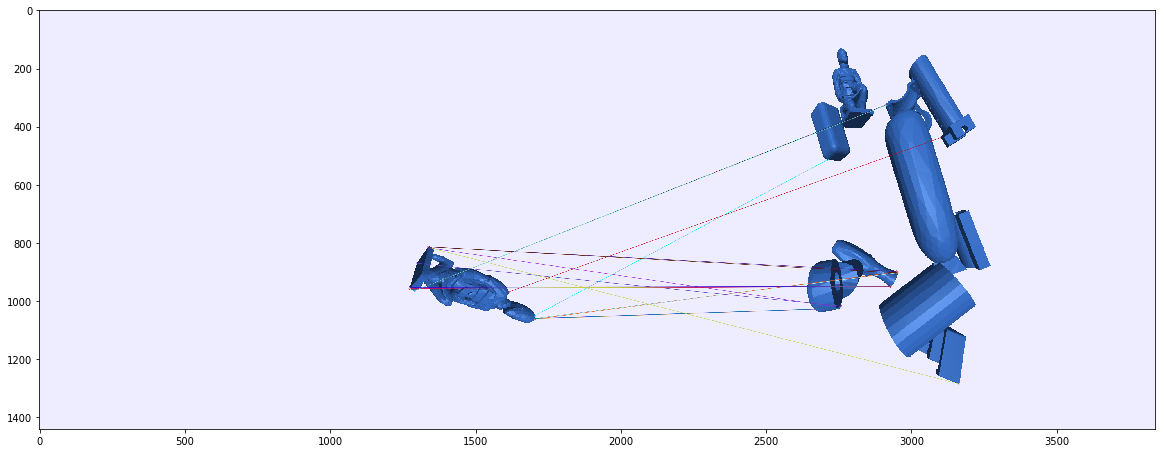

Heap: 45
normalizing descriptor norm
normalizing descriptor norm
Using openCV norm_hammings


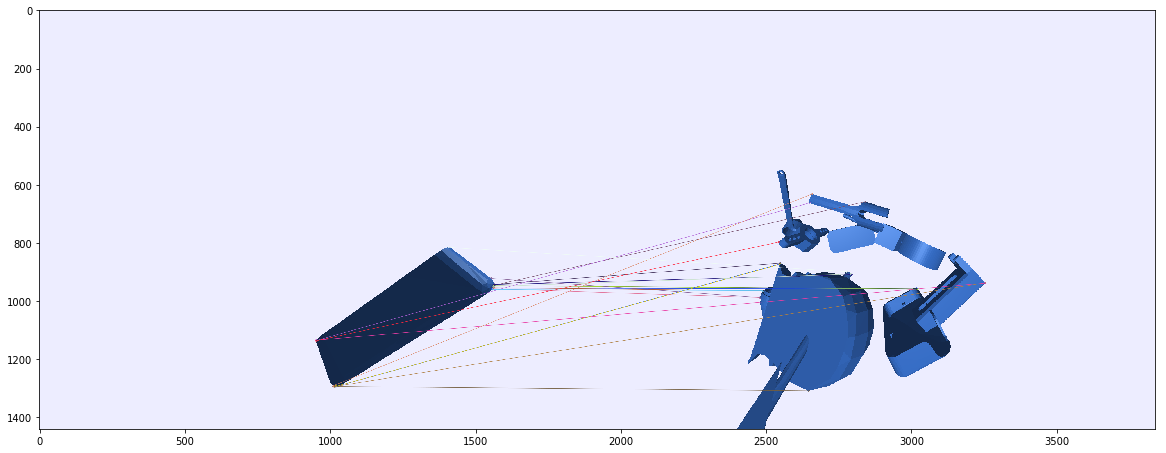

Heap: 46
normalizing descriptor norm
normalizing descriptor norm
Using openCV norm_hammings


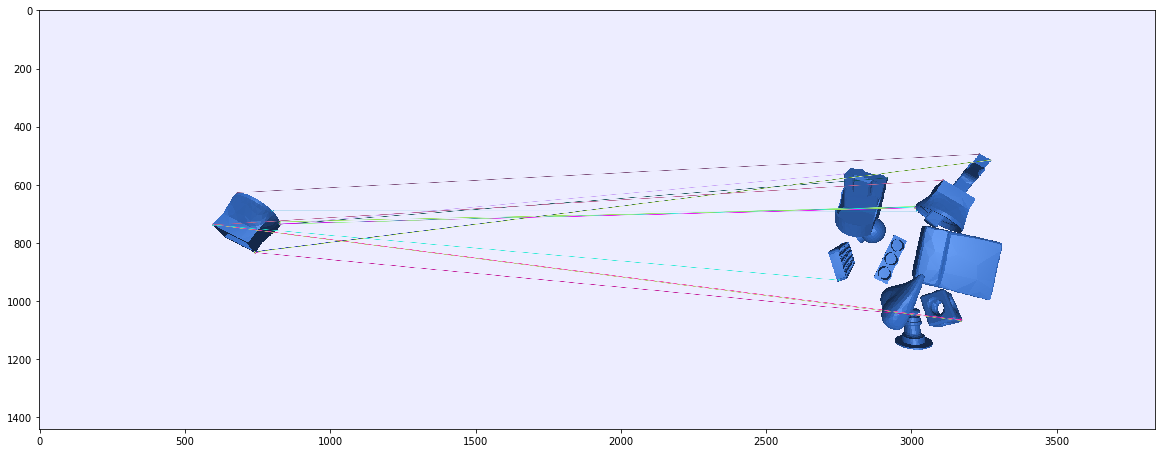

Heap: 47
normalizing descriptor norm
normalizing descriptor norm
Using openCV norm_hammings


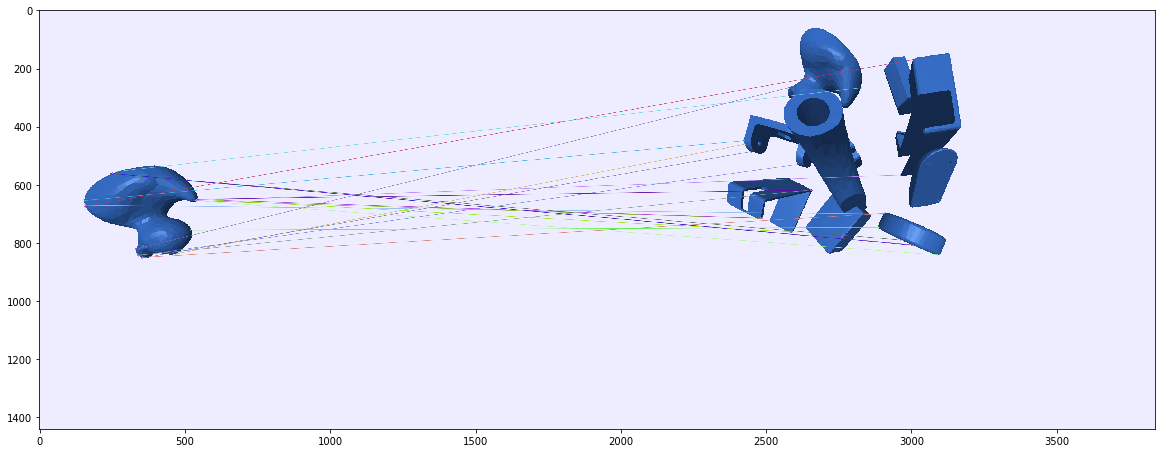

Heap: 48
normalizing descriptor norm
normalizing descriptor norm
Using openCV norm_hammings


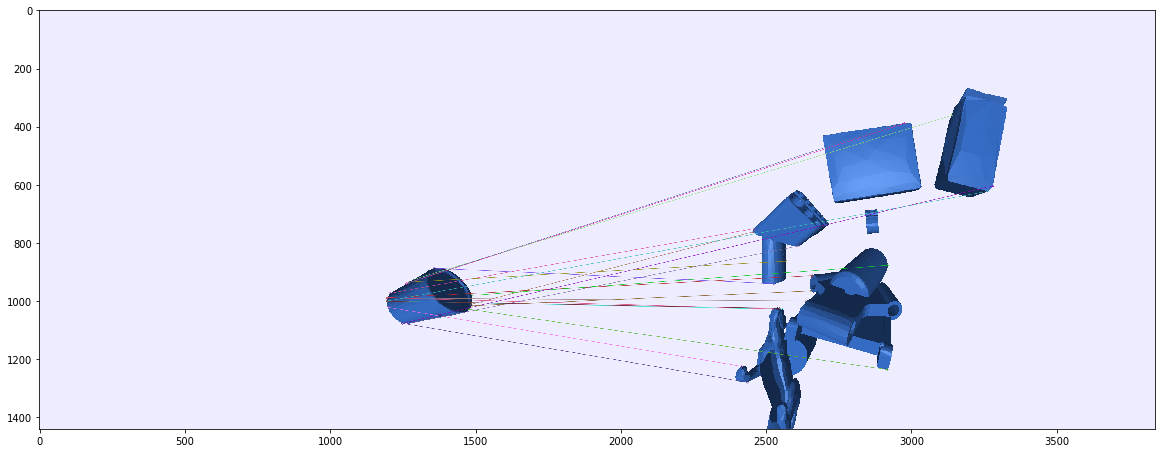

Heap: 49
normalizing descriptor norm
normalizing descriptor norm
Using openCV norm_hammings


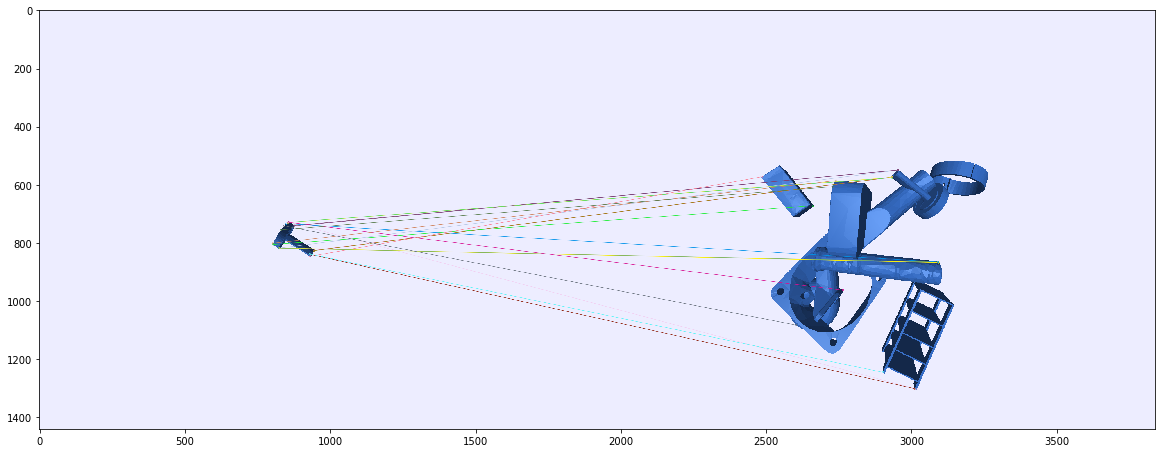

In [4]:
for heap_num in range(50):
    # run_dense_descriptor_original_match(dcn, dataset, )
#     heap_num = 0

    if heap_num in [2, 6]:
        continue

    print("Heap: {}".format(heap_num))
    dirname = "/home/davidtseng/pytorch-dense-correspondence/dense_correspondence/experiments/mech_search/images/heatmap/10_objs_1_0_ratio_perturbed_80deg"
    # 80 deg
    target_img = Image.open(dirname + "/{}/target/rgb.png".format(heap_num)).convert('RGB')
    target = np.array(target_img)
    target_mask = np.load(dirname + "/{}/target/mask.npy".format(heap_num)).astype(np.bool)
    target_descriptors = run_dcn_on_image(dcn, dataset, target_img)

    heap_img = Image.open(dirname + "/{}/heap/rgb.png".format(heap_num)).convert('RGB')
    heap = np.array(heap_img)
    heap_mask = np.load(dirname + "/{}/heap/mask.npy".format(heap_num)).astype(np.bool)
    heap_descriptors = run_dcn_on_image(dcn, dataset, heap_img)


    # DCE.single_image_pair_qualitative_analysis(dcn, dataset, target, heap, target_mask, heap_mask, num_matches=20, patch_size=None)
#     run_dense_descriptor_original_match_with_filtering(dcn, dataset, target, heap, target_mask, heap_mask, target_descriptors, heap_descriptors, top_num_matches=20)
    run_ORB(heap, target, num_matches=20)